In [ ]:
import os, json, re, string
from collections import defaultdict
import matplotlib.pyplot as plt
import pandas as pd

results_dir = "results"
files = {
    "Qwen2.5-7B": "predictions_techqa_llama.jsonl",
    "LLaMA-3.1-8B": "predictions_techqa_qwen.jsonl"
}
csv_out = "squadv2_metrics_em_f1.csv"

def normalize_answer(s: str) -> str:
    if s is None:
        return ""
    s = s.lower()
    exclude = set(string.punctuation)
    s = "".join(ch for ch in s if ch not in exclude)
    s = re.sub(r"\b(a|an|the)\b", " ", s)
    s = " ".join(s.split())
    return s

def f1_score(prediction: str, ground_truth: str) -> float:
    pred = normalize_answer(prediction).split()
    gold = normalize_answer(ground_truth).split()
    if len(gold) == 0 and len(pred) == 0:
        return 1.0
    if len(gold) == 0 or len(pred) == 0:
        return 0.0
    common = defaultdict(int)
    for t in gold:
        common[t] += 1
    num_same = 0
    for t in pred:
        if common[t] > 0:
            num_same += 1
            common[t] -= 1
    if num_same == 0:
        return 0.0
    precision = num_same / len(pred)
    recall = num_same / len(gold)
    return 2 * precision * recall / (precision + recall)

def exact_match_score(prediction: str, ground_truth: str) -> int:
    return int(normalize_answer(prediction) == normalize_answer(ground_truth))

def read_jsonl(path):
    with open(path, "r", encoding="utf-8") as f:
        for line in f:
            if line.strip():
                yield json.loads(line)

def evaluate_file(jsonl_path: str):
    total = 0
    em_sum = 0
    f1_sum = 0.0
    for ex in read_jsonl(jsonl_path):
        pred = ex.get("predicted_answer", "")
        gold = ex.get("gold_answer", "")
        em_sum += exact_match_score(pred, gold)
        f1_sum += f1_score(pred, gold)
        total += 1
    if total == 0:
        return {"exact": 0.0, "f1": 0.0, "total": 0}
    return {
        "exact": 100.0 * em_sum / total,
        "f1": 100.0 * (f1_sum / total),
        "total": total
    }

rows = []
for model, fname in files.items():
    path = os.path.join(results_dir, fname)
    if os.path.exists(path):
        res = evaluate_file(path)
        rows.append({"model": model, "EM": res["exact"], "F1": res["f1"], "total": res["total"]})
    else:
        rows.append({"model": model, "EM": None, "F1": None, "total": 0})

df = pd.DataFrame(rows)

plot_df = df.dropna(subset=["EM", "F1"]).copy()

# Sort by F1 desc for nicer comparison
if len(plot_df) > 0:
    plot_df = plot_df.sort_values(by="F1", ascending=False)

df.to_csv(csv_out, index=False)

plt.figure(figsize=(10, 6))

if len(plot_df) > 0:
    models = plot_df["model"].tolist()
    x = range(len(models))
    bar_width = 0.35

    em_scores = plot_df["EM"].tolist()
    f1_scores = plot_df["F1"].tolist()

    em_bars = plt.bar([i - bar_width/2 for i in x], em_scores, width=bar_width, label="EM")
    f1_bars = plt.bar([i + bar_width/2 for i in x], f1_scores, width=bar_width, label="F1")

    plt.xticks(list(x), models, rotation=15)
    plt.ylabel("Score (%)")
    plt.ylim(0, 100)
    plt.title("SQuAD v2.0 Manual Evaluation: EM vs F1")

    # Add value labels on bars
    def autolabel(bars):
        for b in bars:
            h = b.get_height()
            plt.text(b.get_x() + b.get_width()/2, h + 1, f"{h:.1f}", ha='center', va='bottom', fontsize=9)
    autolabel(em_bars)
    autolabel(f1_bars)

    plt.grid(axis="y", linestyle="--", alpha=0.4)

    plt.legend()
else:
    plt.text(0.5, 0.5, "No evaluable models found.\n(Check file paths.)", ha="center", va="center")
    plt.axis("off")

plt.tight_layout()
plt.show()

---

## Finetuning

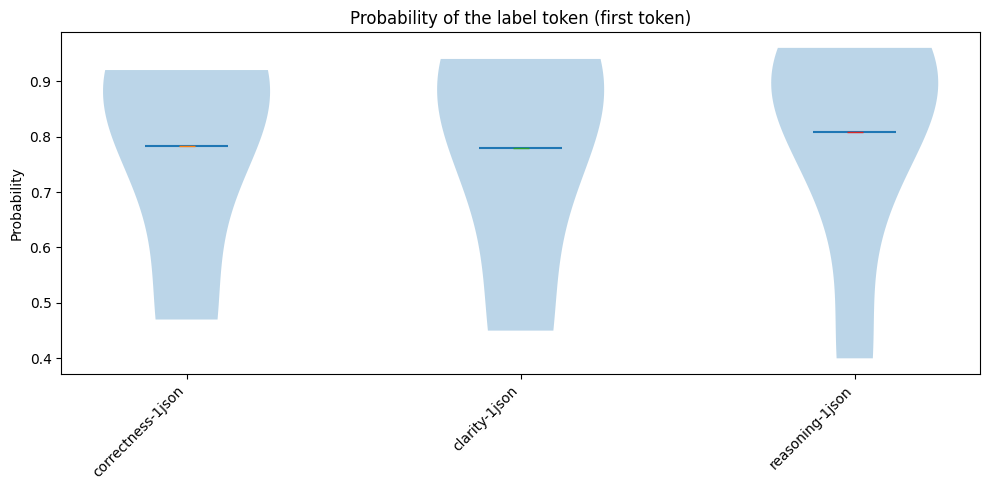

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

dfs = [pd.read_csv(p) for p in ['test.csv']]
df = pd.concat(dfs, ignore_index=True)

if "dimension" not in df.columns:
    df["dimension"] = "grounding-1json"

dims = list(df["dimension"].dropna().unique())
data = [df.loc[df["dimension"] == d, "confidence"].dropna().values for d in dims]

# Prepare figure
fig, ax = plt.subplots(figsize=(10, 5))
parts = ax.violinplot(data, showmeans=True, showmedians=False, showextrema=False)

# X-ticks / labels
ax.set_xticks(np.arange(1, len(dims) + 1))
ax.set_xticklabels(dims, rotation=45, ha="right")
ax.set_ylabel("Probability")
ax.set_title("Probability of the label token (first token)")

for i, arr in enumerate(data, start=1):
    if len(arr) > 0:
        ax.plot([i], [np.mean(arr)], marker="_", markersize=12)

plt.tight_layout()

## Plot Training Losses

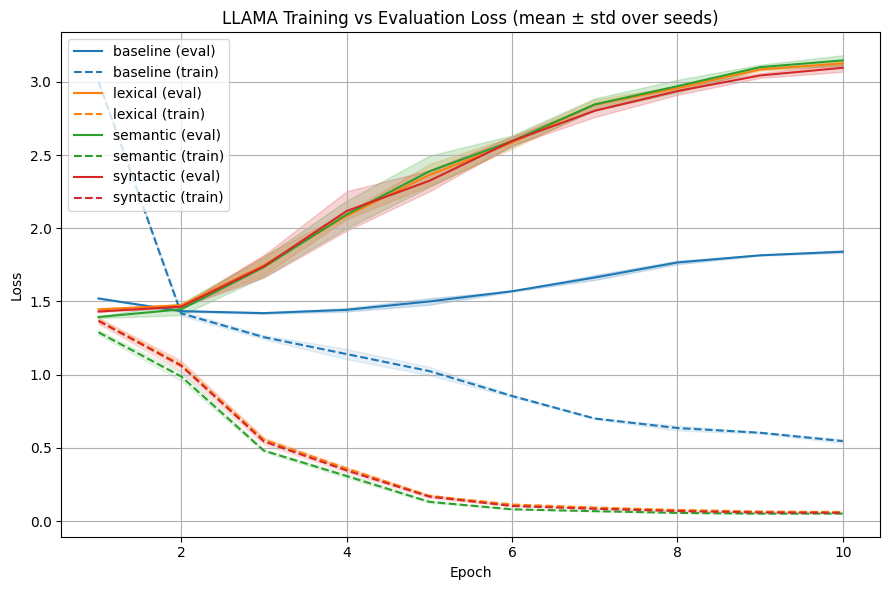

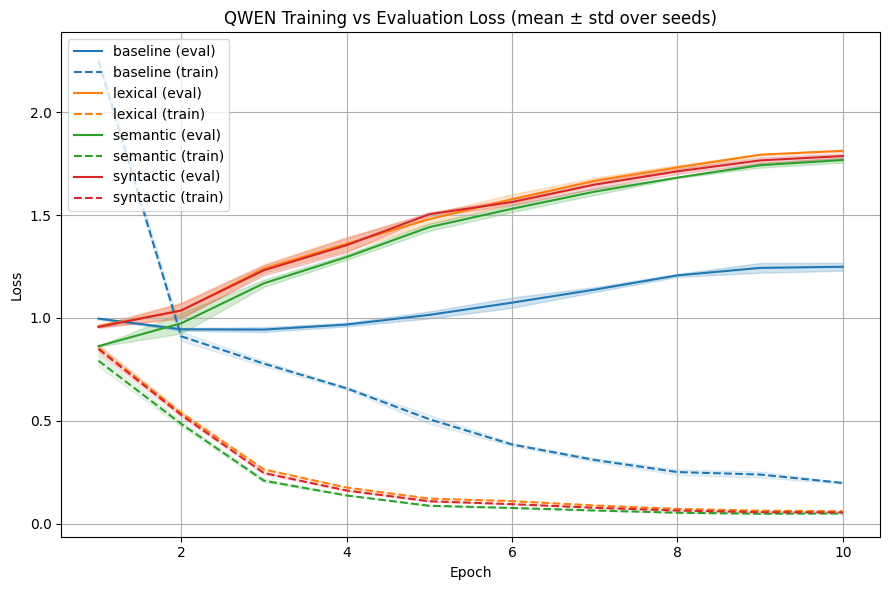

In [4]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

# Path to runs directory
RUNS_DIR = Path("runs_unsloth")

# Models & configs
models = ["llama", "qwen"]
settings = ["baseline", "lexical", "semantic", "syntactic"]
seeds = ["13", "37", "101"]

results = {}

for model in models:
    results[model] = {}
    for setting in settings:
        all_runs = []
        for seed in seeds:
            files = list(RUNS_DIR.glob(f"*_{model}_{setting}_seed{seed}/epoch_losses.csv"))
            if not files:
                continue
            df = pd.read_csv(files[0])
            all_runs.append(df)

        if not all_runs:
            continue

        df_all = pd.concat(
            [df.set_index("epoch")[["train_loss", "eval_loss"]] for df in all_runs],
            axis=1, keys=range(len(all_runs))
        )

        train_mean = df_all.xs("train_loss", axis=1, level=1).mean(axis=1)
        train_std  = df_all.xs("train_loss", axis=1, level=1).std(axis=1)

        eval_mean = df_all.xs("eval_loss", axis=1, level=1).mean(axis=1)
        eval_std  = df_all.xs("eval_loss", axis=1, level=1).std(axis=1)

        results[model][setting] = {
            "epoch": df_all.index,
            "train_mean": train_mean, "train_std": train_std,
            "eval_mean": eval_mean, "eval_std": eval_std,
        }

colors = {
    "baseline": "tab:blue",
    "lexical": "tab:orange",
    "semantic": "tab:green",
    "syntactic": "tab:red",
}

for model in models:
    fig, ax = plt.subplots(figsize=(9,6))
    for setting in settings:
        if setting not in results[model]:
            continue

        e = results[model][setting]["epoch"]

        # Eval loss (solid)
        m_eval = results[model][setting]["eval_mean"]
        s_eval = results[model][setting]["eval_std"]
        ax.plot(e, m_eval, label=f"{setting} (eval)", color=colors[setting], linestyle="-")
        ax.fill_between(e, m_eval-s_eval, m_eval+s_eval, alpha=0.2, color=colors[setting])

        # Train loss (dashed)
        m_train = results[model][setting]["train_mean"]
        s_train = results[model][setting]["train_std"]
        ax.plot(e, m_train, label=f"{setting} (train)", color=colors[setting], linestyle="--")
        ax.fill_between(e, m_train-s_train, m_train+s_train, alpha=0.1, color=colors[setting])

    ax.set_title(f"{model.upper()} Training vs Evaluation Loss (mean ± std over seeds)")
    ax.set_xlabel("Epoch")
    ax.set_ylabel("Loss")
    ax.legend()
    ax.grid(True)
    plt.tight_layout()
    plt.show()
